## Week6

In this part, we'll load a pre-trained network and play with it.

In [47]:
from __future__ import print_function
from sys import version_info

import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import theano
import theano.tensor as T
import lasagne

try:
    import cPickle as pickle
except ImportError:
    import pickle

%matplotlib inline

from tqdm import tqdm
from scipy.misc import imread, imsave, imresize
from lasagne.utils import floatX

# Model Zoo (4 pts)
Lasagne has a plethora of pre-training netrworks in the [model zoo](https://github.com/Lasagne/Recipes/tree/master/modelzoo)
* Even more models within the community (neighbor repos, PRs, etc.)


We'll start by picking VGG16 and deploying it in our notebook.

__Warning!__ VGG16 network requires around 3GB of memory to predict event for single-image batch. If you don't have that luxury, try [binder](http://mybinder.org/repo/yandexdataschool/practical_rl) or [azure notebooks](http://notebooks.azure.com/).


In [ ]:
!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl -O weights.pkl

In [48]:
# copyright: see http://www.robots.ox.ac.uk/~vgg/research/very_deep/

from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.nonlinearities import softmax


def build_model():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(
        net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(
        net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(
        net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(
        net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(
        net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(
        net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(
        net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(
        net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(
        net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(
        net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(
        net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(
        net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(
        net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(
        net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

In [49]:
#classes' names are stored here
classes = pickle.load(open('classes.pkl', 'rb'))
#for example, 10th class is ostrich:
print(classes[9])

ostrich, Struthio camelus


You have to implement two functions in the cell below.

Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 3, 224, 224). Without this transformation, our net won't be able to digest input image. 
Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [50]:
MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224

def preprocess(img):
    img = img[:, :, ::-1]
    img = img - MEAN_VALUES
    
    #convert from [w,h,3 to 1,3,w,h]
    img = np.transpose(img, (2, 0, 1))[None]
    return floatX(img)

def deprocess(img):
    img = img.reshape(img.shape[1:]).transpose((1, 2, 0))
    for i in range(3):
        img[:,:, i] += MEAN_VALUES[i]
    return img[:, :, :: -1].astype(np.uint8)

img = (np.random.rand(IMAGE_W, IMAGE_W, 3) * 256).astype(np.uint8)

print(np.linalg.norm(deprocess(preprocess(img)) - img))

0.0


If your implementation is correct, the number above will be small, because deprocess function is the inverse of preprocess function

### Deploy the network

In [5]:
net = build_model()

In [6]:
with open('weights.pkl', 'rb') as f:
    if version_info.major == 2:
        weights = pickle.load(f)
    elif version_info.major == 3:
        weights = pickle.load(f, encoding='latin1')
    
lasagne.layers.set_all_param_values(net['prob'], weights['param values'])

In [7]:
input_image = T.tensor4('input')
output = lasagne.layers.get_output(net['prob'], input_image, deterministic=True)

prob = theano.function([input_image], output) 

### Sanity check
Let's make sure our network actually works. 

To do so, we'll feed it with some example images.

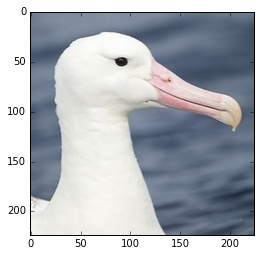

top-5 classes are:
0.996635	albatross
0.003360	goose
0.000001	drake
0.000001	white stork
0.000001	spoonbill


In [8]:
img = imread('sample_images/albatross.jpg')
plt.imshow(img)
plt.show()

p = prob(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

##### Ouch!
Try running network 2-3 times. If output changes, then we've probably done something wrong.

Figure out, what's the problem with the network.

_hint_ there are two such 'problematic' layers in vgg16. They're all near the end.

You can make network deterministic by giving it such flag in the `lasagne.layers.get_output` function above.

#### Fun opportunity

ImageNet does not contain any human classes, so if you feed the network with some human photo, it will most likely hallucinate something which is closest to your image.

Try feeding the network with something peculiar: your avatar, Donald Trump, Victor Lempitsky or anyone.

# Grand-quest: Dogs Vs Cats (6 pts)
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [ ]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip
#you may need to adjust paths in the next section, depending on your OS

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [51]:
input_image = T.tensor4('input')
output = lasagne.layers.get_output(net['fc7'], input_image, deterministic=True)
feats = theano.function([input_image], output) 

In [ ]:
X = []
Y = []

#this may be a tedious process. If so, store the results in some pickle and re-use them.
for fname in tqdm(os.listdir('train/')):
    y = fname.startswith("cat")
    img = imread("train/"+fname)
    img = preprocess(imresize(img,(IMAGE_W, IMAGE_W)))
    features = feats(img)
    Y.append(y)
    X.append(features)

In [ ]:
#with open('image_feats.pkl', 'wb') as f:
    #pickle.dump((X, Y), f)

In [52]:
with open('fc7_features.pkl', 'rb') as f:
    feats = pickle.load(f, encoding='bytes')
X, Y = feats

In [53]:
if type(X) is list:
    X = np.concatenate(X) #stack all [1xfeature] matrices into one. 
    assert X.ndim==2
    #WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = np.array(Y[:len(X)])

In [54]:
from sklearn.model_selection import StratifiedKFold
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score

def cv_evaluate(algo, x, y, train_index, test_index):
        algo.fit(x[train_index], y[train_index])
        pred = algo.predict(x[test_index])
        score = accuracy_score(y[test_index], pred)
        return score

def cross_validation(algo, x, y, n=10):
    kfold = StratifiedKFold(n_splits=n, shuffle=True, random_state=0)
    scores = Parallel(n_jobs=n)(delayed(cv_evaluate)(algo, x, y, train_index, test_index) 
             for train_index, test_index in kfold.split(x, y))
    return np.mean(scores)

In [55]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10,
                            criterion='gini',
                            n_jobs=2,
                            random_state=0)

score = cross_validation(rf, X, np.array(Y), 5)
print(score)

0.97528


# Main quest

* Get the score improved!

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.

The main requirement is that you implement the NN fine-tuning recipe:
### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k
### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout
### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output
### Train the newly added layers for some iterations
  * you can selectively train some weights by only sending them to your optimizer
      * `lasagne.updates.mysupermegaoptimizer(loss, only_those_weights_i_wanna_train)`
  * selecting all weights from the head but not below the neck:
      * `all_params = lasagne.layers.get_all_params(new_output_layer_or_layers,trainable=True)`
      * `old_params= lasagne.layers.get_all_params(neck_layers,trainable=True)`
      * `new_params = [w for w in all_params if w not in old_params]`
  * it's cruicial to monitor the network performance at this and following steps
### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
      * since updates are dictionaries, one can just compute union
      * `updates = {}`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * make sure they do not have overlapping keys. Otherwise, earlier one will be forgotten.
      * `assert len(updates) == len(old_updates) + len(new_updates)`
### PROFIT!!!
  * Evaluate the final score
  * Submit to kaggle
      * competition page https://www.kaggle.com/c/dogs-vs-cats
      * get test data https://www.kaggle.com/c/dogs-vs-cats/data
  
## Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 85%/90%/93%/95%/97% kaggle score (screen pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [9]:
def get_data():
    image_names = []
    targets = []
    for fname in os.listdir('train/'):
        y = fname.startswith("cat")
        targets.append(y)
        image_names.append(fname)
    
    return np.array(image_names), np.array(targets, dtype='int32')

def read_images(names):
    images = []
    for fname in names:
        img = imread("train/"+fname)
        img = preprocess(imresize(img, (IMAGE_W, IMAGE_W)))
        images.append(img)
    
    return np.concatenate(images)

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):    
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
            
        yield read_images(inputs[excerpt]), targets[excerpt]

In [10]:
from sklearn.model_selection import train_test_split

x_data, y_data = get_data()

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=5000, stratify=y_data, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=5000, stratify=y_train, random_state=0)

In [15]:
from lasagne.nonlinearities import rectify, sigmoid

input_image = T.tensor4('input')
targets = T.ivector('targets')
                        
net['new_fc7'] = DenseLayer(net['fc6'], num_units=256, nonlinearity=rectify)
net['new_proba'] = DenseLayer(net['new_fc7'], num_units=1, nonlinearity=sigmoid)

old_params = lasagne.layers.get_all_params(net['fc6'], trainable=True)
params = [p for p in lasagne.layers.get_all_params(net['new_proba'], trainable=True)
         if p not in old_params]

output = lasagne.layers.get_output(net['new_proba'], input_image, deterministic=True)
loss_train = lasagne.objectives.binary_crossentropy(output, targets).mean()
loss_val = lasagne.objectives.binary_crossentropy(output, targets).mean()

update = lasagne.updates.adam(loss_train, params)
train_func = theano.function(inputs=[input_image, targets], outputs=loss_train, updates=update)
val_func = theano.function(inputs=[input_image, targets], outputs=loss_val)

In [34]:
n_epoch = 100
batch_size = 16;

for i in tqdm(range(n_epoch)):
    train_err = 0
    train_batches = 0
    for batch in iterate_minibatches(x_train, y_train, batch_size, shuffle=True):
        inputs, targets = batch
        err = train_func(inputs, targets)
        print("train loss = {}" .format(err))
        train_err += err
        train_batches += 1
        
    val_err = 0
    val_batches = 0
    for batch in iterate_minibatches(x_val, y_val, batch_size, shuffle=False):
        inputs, targets = batch
        err = val_func(inputs, targets)
        print("val loss = {}" .format(err))
        val_err += err
        val_batches += 1
        
    print("epoch {0}: train loss = {1}, val loss = {2}" .format(i, train_err / train_batches, val_err / val_batches))

  0%|          | 0/100 [00:00<?, ?it/s]

train loss = 1.9771428635188752e-05
train loss = 0.001544739490902246
train loss = 0.0004184928555971837


KeyboardInterrupt: 

In [45]:
input_image = T.tensor4('input')
targets = T.ivector('targets')
output = lasagne.layers.get_output(net['new_proba'], input_image, deterministic=True)

accuracy_score = lasagne.objectives.binary_accuracy(output, targets).mean()
accuracy_func = theano.function(inputs=[input_image, targets], outputs=accuracy_score)

test_acc = 0
test_batches = 0
batch_size = 16
for batch in iterate_minibatches(x_test, y_test, batch_size, shuffle=False):
    inputs, targets = batch
    acc = accuracy_func(inputs, targets)
    print("test acc = {}" .format(acc))
    test_acc += acc
    test_batches += 1
    
print("result acc = {}" .format(test_acc / test_batches))

test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 0.9375
test acc = 1.0
test acc = 1.0
test acc = 0.875
test acc = 0.9375
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 0.9375
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 0.9375
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 1.0
test acc = 0.9375
test acc = 1.0
test acc

In [46]:
print("result acc = {}" .format(test_acc / test_batches))

result acc = 0.9883814102564102


Жизнь-боль, когда gpuхи 0. 